# Analysis of Yelp Data
_Research project completed by Allysa Grace Fontillas for Udacity's Data Analyst Nanodegree Program | November 9, 2023_
## Table of Contents
<ul>
<li><a href="#Introduction">Introduction</a></lii>
<li><a href="#Gather Data">Gather Data</a></li>
<li><a href="#Assess Data">Assess Data</a></li>
<li><a href="#Clean Data">Clean Data</a></li>
<li><a href="#Updating the Data Storage">Updating the Data Storage</a></li>
<li><a href="#Answering Research Questions">Answering Research Questions</a></li>
<li><a href="#Conclusions">Conclusions</a></li>
<li><a href="#Reflection">Reflection</a></li>
</ul>
</ul>

## Introduction

In this project, I will retrieve and extract data from two different datasets, assess it, clean it, and use it to answer my research questions.
This project will focus on Yelp data about businesses in the United States. 

The first dataset contains information from Yelp's Open Dataset, a subset of Yelp's data. The Yelp Open Dataset is provided by Yelp as an all-purpose dataset for individuals to learn from. I downloaded this dataset manually and utilized the json file regarding businesses' check-in information. The variables in this dataset are `business_id` and `date`. Each value in the `date` column contains all of the dates and times that a user checked-in at a business.

I used the Yelp Fusion API to gather the second dataset. I submitted an application on Yelp's Developers website where I was granted a client ID and an API key to access the Yelp Fusion API. The second dataset focuses on the different attributes of each `business_id` from the first dataset. The variables for the second dataset are `business_id`, `name`, `rating`, `review_count`, `category`, `city`, `state`, and `zip_code`.

With these 2 datasets, I sought to answer the following questions:
- What is the average rating of businesses based on their amount of reviews and how are these 2 variables related?
- What is the average rating of businesses based on their amount check-ins and how are these 2 variables related?
- What is the relationship between Yelp user interactions (check-ins + reviews) and the rating given to a business?

I initially considered focusing on businesses with the highest ratings, but I realized that metric can be unreliable. Multiple businesses have a 5-star review on yelp and a low count of reviews (<15 reviews) and check-ins, so querying for business data based on rating wouldn't necessarily gather businesses with a lot of user interactions.

In [1]:
#Imports the libraries I'll be using
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl as op
import seaborn as sns
import json

## Gather Data

#### **Dataset 1**
The first dataset contains business check-in information from Yelp's Open Dataset. I obtained this json file by downloading it manually from Yelp's online Open Dataset. I chose this dataset to acquire the check-in information of different businesses. After I've assessed and cleaned this data, I will analyze the relationship between the amount of check-ins and a business' rating. The variables in this current dataset are `business_id` and `date`. As you can see, some businesses have more dates than others. This is because Yelp's Open Dataset stores check-ins by storing the date of each check-in rather than the number of check-ins. 

I will load in this dataset below.

In [2]:
checkIn = pd.read_json('yelpdataset_checkin.json', lines=True)
checkIn.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


The `date` column of this dataframe stores the date of every check-in for each `business_id`.

Some businesses don't have a lot of check-ins or Yelp user interactions. To ensure that I work with a dataset that contains businesses with plenty of Yelp user interactions, I want to keep the top 600 businesses with the most check-ins from Yelp's Open Dataset. To do that, I will sort the dataframe based on the length of each value in the `date` column and keep the top 600 rows with the longest `date` value length.

In [3]:
#Made a copy of CheckIn and stored it into a new dataframe called SortedCheck
sortedCheck = checkIn.copy()
#Creates a new column that lists the length of each value from the date column so I can easily see it
sortedCheck['dateLength'] = checkIn.date.str.len()

In [4]:
#Stores the index of the sorted date length values into the variable "s"
s = checkIn.date.str.len().sort_values(ascending=False).index

In [5]:
#Uses the stored index in "s" to keep the date with its corresponding business_id and resets the index to 0
sortedCheck = sortedCheck.reindex(s).reset_index(drop=True)
sortedCheck

,business_id,date,dateLength
0,-QI8Qi8XWH3D8y8ethnajA,"2010-01-17 16:30:46, 2010-01-18 20:17:55, 2010...",1095022
1,FEXhWNCMkv22qG04E83Qjg,"2010-01-16 07:39:02, 2010-01-17 14:04:18, 2010...",842287
2,Eb1XmmLWyt_way5NNZ7-Pw,"2010-01-21 19:43:12, 2010-02-03 10:17:21, 2010...",788800
3,c_4c5rJECZSfNgFj7frwHQ,"2010-02-06 18:03:00, 2010-02-08 00:06:52, 2010...",787876
4,4i4kmYm9wgSNyF1b6gKphg,"2010-01-21 19:31:34, 2010-01-26 22:12:24, 2010...",654526
...,...,...,...
131925,vo_ExfVtnzWTwedmFCpzXQ,2018-10-31 21:09:27,19
131926,m44uqdqZyz7AQJhcCu7DUg,2014-07-15 02:53:02,19
131927,vojJhH78rcYpDFPft5dCyA,2017-06-06 19:20:45,19
131928,volXGKIzsd9y_pvZb3dB7A,2019-07-08 20:26:20,19


In [6]:
#Dropping the datelength column because I've confirmed this code functions as intended
sortedCheck.drop('dateLength', axis=1, inplace=True)
#Keeping only the first 600 rows
sortedCheck.drop(sortedCheck.index[600:131930], inplace=True)

In [7]:
sortedCheck.head()

,business_id,date
0,-QI8Qi8XWH3D8y8ethnajA,"2010-01-17 16:30:46, 2010-01-18 20:17:55, 2010..."
1,FEXhWNCMkv22qG04E83Qjg,"2010-01-16 07:39:02, 2010-01-17 14:04:18, 2010..."
2,Eb1XmmLWyt_way5NNZ7-Pw,"2010-01-21 19:43:12, 2010-02-03 10:17:21, 2010..."
3,c_4c5rJECZSfNgFj7frwHQ,"2010-02-06 18:03:00, 2010-02-08 00:06:52, 2010..."
4,4i4kmYm9wgSNyF1b6gKphg,"2010-01-21 19:31:34, 2010-01-26 22:12:24, 2010..."


#### Dataset 2
The second dataset contains business information from Yelp's API, Yelp Fusion API. This API allows me to use API calls to gather additional information about each `business_id` value in the `sortedCheck` dataframe. I will query for these businesses' `name`, `rating`, `review_count`, `category`, `city`, `state`, and `zip_code`. These will be the variables in the second dataset.

Even though I already know the `business_id` of each business (gathered from the first dataset), I will query for the `id`s in the second dataset as well. This will make combining the 2 datasets easier because the `business_id` will serve as the key.

The Yelp Fusion API only allows 500 API calls per day. The API call limit resets at 4PM Pacific Standard Time. Since I have 600 rows in this dataset, I will split the `business_id`s into 2 lists. Then I will take advantage of the reset at 4PM and query `listId1` before 4PM and `listId2` after 4PM.

In [8]:
#Converting the business_id column's values to a list
listId = sortedCheck['business_id'].tolist()

#Since my API Key only allows for 500 API calls per day, I will split these 600 business_ids into 2 lists
listId1 = listId[:500]
listId2 = listId[500:]

In [9]:
#Function used to make API requests for each business_id from the first dataset (ListId1 + ListId2)
def getmoredata(id):
    #config is a py file containing just the api key; it keeps my key hidden to comply with Yelp's terms of use
    import config
    api_key = config.api_key
    # Defines the business search and header
    PATH = 'https://api.yelp.com/v3/businesses/'+ id
    HEADER = {'Authorization': 'bearer %s' % api_key,
               'accept': 'application/json'}
    
    #Makes a request to the Yelp API and returns the result
    response = requests.get(url=PATH, 
                            headers=HEADER)
    #Converts the response to a JSON string
    return response.json()

In [10]:
#This extracts specific details of each business using the business_ids from the SortedCheck dataframe 
def obtain(info):
    checkInBiz = []
    singleBiz = []
    #add every detail into singleBiz
    singleBiz.append(info['id'])
    singleBiz.append(info['name'])
    singleBiz.append(info['rating'])
    singleBiz.append(info['review_count'])
    singleBiz.append(info['categories'])
    singleBiz.append(info['location']['city'])
    singleBiz.append(info['location']['state'])
    singleBiz.append(info['location']['zip_code'])
    checkInBiz.append(singleBiz)
    return checkInBiz

First, I made an API call for `listId1` in order to gather data for the first 500 `business_id`s in the `sortedCheck` dataframe and saved the results to a new dataframe and a local csv file titled "businessInfo.csv".

In [11]:
#Initializing the list that will contain all of the data queried for each business_id from the SortedCheck dataframe 
addData = []

#for loop that passes each business_id into the getmoredata function then passes the result into the obtain function to get the specific features of each business_id
for id in listId1:
    info = getmoredata(id)
    addData.extend(obtain(info))

#Puts all of the information added into "addData" into a dataframe
bizInfo1 = pd.DataFrame(addData, columns=['business_id', 'name', 'rating', 'review_count', 'category', 'city', 'state', 'zip_code'])
#Writes this information from the dataframe into a csv file 
bizInfo1.to_csv('businessInfo.csv', mode='a', index=False)

After 4PM, my API call limit reset. I used the same code to make an API call for `listId2` for the *last* 100 `business_id`s in the `sortedCheck` dataframe and saved the results to a new dataframe and a local csv file titled "businessInfo.csv". I saved the results from both API calls into this csv file because it takes days to acquire all of this data.

In [12]:
#Initializing the list that will contain all of the data queried for each business_id from the SortedCheck dataframe 
addData = []

#for loop that passes each business_id into the getmoredata function then passes the result into the obtain function to get the specific features of each business_id
for id in listId2:
    info = getmoredata(id)
    addData.extend(obtain(info))

#Puts all of the information added into "addData" into a dataframe
bizInfo2 = pd.DataFrame(addData, columns=['business_id', 'name', 'rating', 'review_count', 'category', 'city', 'state', 'zip_code'])
#Writes this information from the dataframe into a csv file 
bizInfo2.to_csv('businessInfo.csv', mode='a', index=False, header=False)

In [13]:
#Combining the 2 dataframes into one to combine all 600 rows again
bizData = pd.concat([bizInfo1, bizInfo2])

In [14]:
#Loads the COMPLETE dataset gathered from the 2 API calls
bizData.head()

,business_id,name,rating,review_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,"[{'alias': 'airports', 'title': 'Airports'}]",Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,"[{'alias': 'airports', 'title': 'Airports'}]",Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,Tampa International Airport,4.0,2033,"[{'alias': 'airports', 'title': 'Airports'}]",Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,Nashville International Airport - BNA,3.5,1140,"[{'alias': 'airports', 'title': 'Airports'}]",Nashville,TN,37214


In [15]:
#The code below loads the CSV file I saved both of the API calls to. I made this CSV file because it takes multiple days to acquire this data
#due to Yelp's daily API limit.
bizDataCsv = pd.read_csv('businessInfo.csv')
bizDataCsv.head()

,business_id,name,rating,review_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,"[{'alias': 'airports', 'title': 'Airports'}]",Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,"[{'alias': 'airports', 'title': 'Airports'}]",Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,Tampa International Airport,4.0,2033,"[{'alias': 'airports', 'title': 'Airports'}]",Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,Nashville International Airport - BNA,3.5,1140,"[{'alias': 'airports', 'title': 'Airports'}]",Nashville,TN,37214


Due to Yelp's daily API limit, I don't expect the project reviewer to be able to request and acquire the data for `listId1` and `listId2` in one day. I was able to do it in one day because I sent the API request for `listId1` before 4PM (PST) and then I sent the request for `listId2` after 4PM (PST).
To ensure the code for the second dataset runs as intended on the reviewer's end, I will use the variable `bizDataCsv` to refer to the second dataset.

## Assess Data
I will assess the `sortedCheck` and the `bizDataCsv` dataframe visually and programmatically for data quality issues and data tidiness issues.

In [16]:
sortedCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  600 non-null    object
 1   date         600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [17]:
sortedCheck.isnull().sum()

business_id    0
date           0
dtype: int64

In [18]:
sortedCheck.duplicated().sum()

0

In [19]:
sortedCheck.nunique()

business_id    600
date           600
dtype: int64

In [20]:
sortedCheck.head(3)

,business_id,date
0,-QI8Qi8XWH3D8y8ethnajA,"2010-01-17 16:30:46, 2010-01-18 20:17:55, 2010..."
1,FEXhWNCMkv22qG04E83Qjg,"2010-01-16 07:39:02, 2010-01-17 14:04:18, 2010..."
2,Eb1XmmLWyt_way5NNZ7-Pw,"2010-01-21 19:43:12, 2010-02-03 10:17:21, 2010..."


The `sortedCheck` dataframe is complete, it has no missing values. All of the `business_id` values are unique and this dataframe does not contain any duplicated rows. The `.info()` method shows that the `date` column's values are stored as an `object` data type, when dates are usually stored as a `datetime` data type. Normally, this would be a data quality issue. The values stored in `date` consist of a *string* of multiple check-in dates, so I understand why this wasn't stored as a `datetime` data type.
For the end-goal of this project, I will have this dataframe store the number of check-ins rather than the dates of the check-ins.

### Tidiness Issue #1: Multiple variables are stored in 1 column

The `sortedCheck` dataframe currently stores multiple variables in one column. It stores the total number of check-ins and the dates of when people checked into a business in the `date` column.
To address this issue, I will find out how many check-ins there are for each business. Then I will create a column called `checkin_count` and its values will be the number of check-ins that each business has. Lastly, I will drop the `date` column because I'm not interested in the specific date of each check-in for this project.

Now I will assess the `bizDataCsv` dataframe for any issues.

In [21]:
bizDataCsv.head()

,business_id,name,rating,review_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,"[{'alias': 'airports', 'title': 'Airports'}]",Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,"[{'alias': 'airports', 'title': 'Airports'}]",Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,Tampa International Airport,4.0,2033,"[{'alias': 'airports', 'title': 'Airports'}]",Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,Nashville International Airport - BNA,3.5,1140,"[{'alias': 'airports', 'title': 'Airports'}]",Nashville,TN,37214


In [22]:
bizDataCsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   600 non-null    object 
 1   name          600 non-null    object 
 2   rating        600 non-null    float64
 3   review_count  600 non-null    int64  
 4   category      600 non-null    object 
 5   city          600 non-null    object 
 6   state         600 non-null    object 
 7   zip_code      600 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 37.6+ KB


The `bizDataCsv` dataframe is complete, it does not have any missing values.

In [23]:
#Confirms that every value in the rating column contains a decimal.
bizDataCsv.rating.unique()

array([2.5, 4. , 3. , 3.5, 4.5, 5. , 2. , 1.5])

In [24]:
#Confirms that every value in the review_count column is only integers
intCheck = pd.to_numeric(bizDataCsv['review_count'], errors='coerce').notnull().sum()
intCheck

600

### Quality Issue #1: Erroneous data type for `zip_code` column
The `zip_code` column has zip code values so I expected this column to have an integer data type. As we can see from the `.info()` method, this column stores values as an `object` data type. To address this issue, I will change the data type of this column to an integer.

In [25]:
bizDataCsv.describe()

,rating,review_count
count,600.000000,600.000000
mean,3.950000,1223.121667
std,0.474737,1153.324368
min,1.500000,14.000000
25%,3.500000,458.000000
50%,4.000000,889.000000
75%,4.500000,1617.000000
max,5.000000,8913.000000


In [26]:
bizDataCsv.duplicated().sum()

0

In [27]:
bizDataCsv.isnull().sum().sum()

0

The `bizDataCsv` dataframe has no duplicated values and no null values. The `.describe()` method reveals that all of the business ids in this dataframe are unique, so there are no duplicate business ids. 

In [28]:
#Checks for zip_codes that does not follow the U.S zip code schema
ziptest = bizDataCsv[bizDataCsv['zip_code'].str.len() != 5]
ziptest

,business_id,name,rating,review_count,category,city,state,zip_code
342,yYyljEUFGkezQXpzRlfqQA,West Edmonton Mall,4.0,223,"[{'alias': 'shoppingcenters', 'title': 'Shoppi...",Edmonton,AB,T5T 4J2


### Quality Issue #2: Out-of-range `zip_code` value that does not follow the U.S zip code schema

The row with an index of `342` is for a business located in Canada. I checked for any `zip_code` values that did not adhere to the schema of 5 digit `zip_code` formats in the United States. This is the only entry that is located in Canada. For consistency, I will remove this row so that the dataframe will only consist of businesses in the United States.

In [29]:
#Checks for any business_ids that aren't 22 characters.
invalid_len = bizDataCsv[bizDataCsv['business_id'].str.len() != 22]
invalid_len

,business_id,name,rating,review_count,category,city,state,zip_code


The Yelp developer portal states that `business_id` values should be 22 characters. All of the `business_id` values in the `bizDataCsv` dataframe are 22 characters long.

Next I will check if the first letter of every word in the `city` column is capitalized.

In [30]:
cityCap = bizDataCsv.query('not city.str.istitle()')
cityCap

,business_id,name,rating,review_count,category,city,state,zip_code
64,iqJ3t9iq0fsWaYL93s8Vmw,King of Prussia,4.0,519,"[{'alias': 'shoppingcenters', 'title': 'Shoppi...",King of Prussia,PA,19406
68,-OKB11ypR4C8wWlonBFIGw,Atlantis Casino Resort Spa,3.5,1421,"[{'alias': 'casinos', 'title': 'Casinos'}, {'a...",RENO,NV,89502


Any short preposition words such as "of" are not expected to be capitalized, so row `64` is an exception to this schema.

Row `68` has a `city` value that is all capitalized.

In [31]:
#Queries for other businesses in Reno
reno = bizDataCsv.query('city == "Reno"')
reno.head()

,business_id,name,rating,review_count,category,city,state,zip_code
11,h0wHeh0hTt6Us4W-1SHQOw,Reno-Tahoe International Airport,4.0,627,"[{'alias': 'airports', 'title': 'Airports'}]",Reno,NV,89502
13,wz8ZPfySQczcPgSyd33-HQ,Grand Sierra Resort and Casino,3.0,3934,"[{'alias': 'hotels', 'title': 'Hotels'}, {'ali...",Reno,NV,89595
25,PY9GRfzr4nTZeINf346QOw,Peppermill Resort Spa Casino,4.0,2771,"[{'alias': 'casinos', 'title': 'Casinos'}, {'a...",Reno,NV,89502
27,mcr1lAEdvGLMJhuPwI3I2A,101 Taiwanese Cuisine,4.0,1353,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",Reno,NV,89503
29,ld_H5-FpZOWm_tkzwkPYQQ,Grande Exposition Hall,3.0,1752,"[{'alias': 'hotels', 'title': 'Hotels'}, {'ali...",Reno,NV,89501


### Quality Issue #3: `city` value in row `68` does not follow schema
We can see that row `68` does not follow the format where only the first letter of each word in `city` is capitalized. When I queried for other businesses in "Reno", I discovered that there are multiple businesses that have their `city` value formatted correctly as "Reno" and not "RENO".

To address this issue, I will change the `city` value of row `68` from "RENO" to "Reno".

In [32]:
#Displays the values for the category column in bizDataCsv dataframe
bizDataCsv['category']

0           [{'alias': 'airports', 'title': 'Airports'}]
1      [{'alias': 'coffee', 'title': 'Coffee & Tea'},...
2           [{'alias': 'airports', 'title': 'Airports'}]
3           [{'alias': 'airports', 'title': 'Airports'}]
4           [{'alias': 'airports', 'title': 'Airports'}]
                             ...                        
595       [{'alias': 'breweries', 'title': 'Breweries'}]
596    [{'alias': 'hotels', 'title': 'Hotels'}, {'ali...
597    [{'alias': 'vietnamese', 'title': 'Vietnamese'...
598    [{'alias': 'sportsbars', 'title': 'Sports Bars...
599    [{'alias': 'tradamerican', 'title': 'American'...
Name: category, Length: 600, dtype: object

### Tidiness Issue #2: `category` column contains multiple redundant values 
Each row in the `category` column currently contains a string that is written in the format of a dictionary despite its data type not being a dictionary. The word after `alias` is written in lowercase letters and appears to be more vague compared to the word after `title`. To make this column neat, I will keep the string after `title` and store that as the value of each row.

## Clean Data

### cleanCheck Dataframe Issues to Address
- **Tidiness Issue**: Multiple variables are stored in 1 column

In [33]:
#Copy of the sortedCheck dataframe
cleanCheck = sortedCheck.copy()

In [34]:
#Loads in the first 2 rows of the dataframe
cleanCheck.head(2)

,business_id,date
0,-QI8Qi8XWH3D8y8ethnajA,"2010-01-17 16:30:46, 2010-01-18 20:17:55, 2010..."
1,FEXhWNCMkv22qG04E83Qjg,"2010-01-16 07:39:02, 2010-01-17 14:04:18, 2010..."


### **Tidiness Issue**: Multiple variables are stored in 1 column
I will count the amount of check-ins for each `business_id` to split the number of check-ins and the check-in dates into 2 columns.

In [35]:
#Counts the length of the values in the date column separated by a comma
cleanCheck['checkin_count'] = cleanCheck['date'].apply(lambda x: len(x.split(',')))

In [36]:
#Confirming that the code above worked
cleanCheck.head()

,business_id,date,checkin_count
0,-QI8Qi8XWH3D8y8ethnajA,"2010-01-17 16:30:46, 2010-01-18 20:17:55, 2010...",52144
1,FEXhWNCMkv22qG04E83Qjg,"2010-01-16 07:39:02, 2010-01-17 14:04:18, 2010...",40109
2,Eb1XmmLWyt_way5NNZ7-Pw,"2010-01-21 19:43:12, 2010-02-03 10:17:21, 2010...",37562
3,c_4c5rJECZSfNgFj7frwHQ,"2010-02-06 18:03:00, 2010-02-08 00:06:52, 2010...",37518
4,4i4kmYm9wgSNyF1b6gKphg,"2010-01-21 19:31:34, 2010-01-26 22:12:24, 2010...",31168


In [37]:
#Dropping the date column because it's no longer needed
cleanCheck.drop('date', axis=1, inplace=True)
#Confirm the drop was successful
cleanCheck.head()

,business_id,checkin_count
0,-QI8Qi8XWH3D8y8ethnajA,52144
1,FEXhWNCMkv22qG04E83Qjg,40109
2,Eb1XmmLWyt_way5NNZ7-Pw,37562
3,c_4c5rJECZSfNgFj7frwHQ,37518
4,4i4kmYm9wgSNyF1b6gKphg,31168


The code above validates that my cleaning for this dataframe was successful.

### bizDataCsv Dataframe Issues to Address:
- **Quality Issue**: Erroneous data type for `zip code` column
- **Quality Issue**: Out-of-range `zip_code` value that does not follow the U.S zip code schema
- **Quality Issue**: `city` value in row `68` does not follow schema
- **Tidiness Issue**: `category` column contains multiple redundant values

In [38]:
#Copy of the bizDataCsv dataframe
cleanBizData = bizDataCsv.copy()

In [39]:
#Loads in the dataframe
cleanBizData.head(2)

,business_id,name,rating,review_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,"[{'alias': 'airports', 'title': 'Airports'}]",Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",New Orleans,LA,70116


*Before* I change the data type of the `zip_code` column, I will need to address the out-of-range `zip_code` value first. The Canadian `zip_code` consists of letters and digits, so I can't change the `zip_code` data type to an integer until I drop row `342` from the dataframe.

### **Quality Issue**: Out-of-range `zip_code` value that does not follow the U.S zip code schema

Since this value is for a business located outside of the United States, I will drop this row.

In [40]:
#Checks for zip_codes that does not follow the U.S zip code schema
ziptest = cleanBizData[cleanBizData['zip_code'].str.len() != 5]
ziptest

,business_id,name,rating,review_count,category,city,state,zip_code
342,yYyljEUFGkezQXpzRlfqQA,West Edmonton Mall,4.0,223,"[{'alias': 'shoppingcenters', 'title': 'Shoppi...",Edmonton,AB,T5T 4J2


In [41]:
#Drops the specific row for the Canadian business
cleanBizData.drop(cleanBizData.index[342], inplace=True)
#Checks again for any zip_codes that don't consist of 5 characters
ziptest = cleanBizData[cleanBizData['zip_code'].str.len() != 5]
ziptest

,business_id,name,rating,review_count,category,city,state,zip_code


This method dropped row `342` successfully. To ensure consistency between both dataframes, I will drop the row with the same `business_id` in the `cleanCheck` dataframe as well.

In [42]:
cleanCheck.query('business_id == "yYyljEUFGkezQXpzRlfqQA"')

,business_id,checkin_count
342,yYyljEUFGkezQXpzRlfqQA,2499


In [43]:
#Drops the corresponding row in the cleanCheck dataframe
cleanCheck.drop(cleanCheck.index[342], inplace=True)
#Checks for the specific business_id to confirm the change was successful
cleanCheck.query('business_id == "yYyljEUFGkezQXpzRlfqQA"')

,business_id,checkin_count


This method was successful. Now I can change the data type of the `zip_code` column.

### **Quality Issue**: Erroneous data type for `zip_code` column

To address this, I will change the data type of `zip_code` from object to integer.

In [44]:
#Changes the data type of zip_code to an integer
cleanBizData['zip_code'] = cleanBizData['zip_code'].astype('int')
#Confirms the change was successful
cleanBizData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, 0 to 599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   599 non-null    object 
 1   name          599 non-null    object 
 2   rating        599 non-null    float64
 3   review_count  599 non-null    int64  
 4   category      599 non-null    object 
 5   city          599 non-null    object 
 6   state         599 non-null    object 
 7   zip_code      599 non-null    int32  
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 39.8+ KB


### **Quality Issue**: `city` value in row `68` does not follow schema

Row `68` does not follow the format where only the first letter of each word in `city` is capitalized. I will address this by changing its `city` value to follow the expected format.

In [45]:
cityCap = cleanBizData.query('not city.str.istitle()')
cityCap

,business_id,name,rating,review_count,category,city,state,zip_code
64,iqJ3t9iq0fsWaYL93s8Vmw,King of Prussia,4.0,519,"[{'alias': 'shoppingcenters', 'title': 'Shoppi...",King of Prussia,PA,19406
68,-OKB11ypR4C8wWlonBFIGw,Atlantis Casino Resort Spa,3.5,1421,"[{'alias': 'casinos', 'title': 'Casinos'}, {'a...",RENO,NV,89502


In [46]:
#Replaces the city value in row 68
cleanBizData['city'] = cleanBizData['city'].replace('RENO', 'Reno')
#Confirms the change was sucessful for the specified row
cleanBizData.loc[68]

business_id                                -OKB11ypR4C8wWlonBFIGw
name                                   Atlantis Casino Resort Spa
rating                                                        3.5
review_count                                                 1421
category        [{'alias': 'casinos', 'title': 'Casinos'}, {'a...
city                                                         Reno
state                                                          NV
zip_code                                                    89502
Name: 68, dtype: object

### **Tidiness Issue**: `category` column contains multiple redundant values

To clean this column, I will remove the string before `title` and keep the string after `title` and store them as the value for each row.

This is what the values for `category` currently looks like:

In [47]:
cleanBizData['category'].head()

0         [{'alias': 'airports', 'title': 'Airports'}]
1    [{'alias': 'coffee', 'title': 'Coffee & Tea'},...
2         [{'alias': 'airports', 'title': 'Airports'}]
3         [{'alias': 'airports', 'title': 'Airports'}]
4         [{'alias': 'airports', 'title': 'Airports'}]
Name: category, dtype: object

In [48]:
#Removes the string before 'title'
cleanBizData['category'] = [x.split("title': '")[-1] for x in cleanBizData['category']]
#Confirms the change was successful
cleanBizData['category']

0                   Airports'}]
1                     Donuts'}]
2                   Airports'}]
3                   Airports'}]
4                   Airports'}]
                 ...           
595                Breweries'}]
596    Venues & Event Spaces'}]
597                     Thai'}]
598                  Burgers'}]
599                 Desserts'}]
Name: category, Length: 599, dtype: object

In [49]:
#Removes the string after `title`
cleanBizData['category'] = [x.split("'}]")[0] for x in cleanBizData['category']]
#Confirms the change was successful
cleanBizData['category']

0                   Airports
1                     Donuts
2                   Airports
3                   Airports
4                   Airports
               ...          
595                Breweries
596    Venues & Event Spaces
597                     Thai
598                  Burgers
599                 Desserts
Name: category, Length: 599, dtype: object

### **Combine datasets**

In [50]:
#Combining the dataframes
data = cleanCheck.merge(cleanBizData, how='outer')
#Loads the first couple rows of the combined dataframe
data.head()

,business_id,checkin_count,name,rating,review_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,52144,Philadelphia International Airport - PHL,2.5,2338,Airports,Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,40109,Cafe Du Monde,4.0,3126,Donuts,New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,37562,Louis Armstrong New Orleans International Airp...,3.0,1969,Airports,Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,37518,Tampa International Airport,4.0,2033,Airports,Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,31168,Nashville International Airport - BNA,3.5,1140,Airports,Nashville,TN,37214


In [51]:
#Rearranges the columns
yelpData = data.iloc[:,[0,2,3,4,1,5,6,7,8]]
yelpData.head()

,business_id,name,rating,review_count,checkin_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,52144,Airports,Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,40109,Donuts,New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,37562,Airports,Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,Tampa International Airport,4.0,2033,37518,Airports,Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,Nashville International Airport - BNA,3.5,1140,31168,Airports,Nashville,TN,37214


## Updating the Data Storage
Now I will update my local database with the cleaned data. I will save both of the cleaned datasets as well as the combined clean dataset.

In [52]:
#Saving cleanCheck dataframe to a CSV file
cleanCheck.to_csv('cleanCheckIns.csv', encoding='utf-8', index=False)

In [53]:
#Saving cleanBizData dataframe to a CSV file
cleanBizData.to_csv('cleanBusinessData.csv', encoding='utf-8', index=False)

In [54]:
#Saving the combined clean dataset to a CSV file
yelpData.to_csv('combinedYelpData.csv', encoding='utf-8', index=False)

## Answering Research Questions

The data has been analyzed, cleaned, and combined. Now it's time to analyze the data to identify patterns, relationships, or any meaningful findings. I will then use my analysis to answer the following research questions:

- What is the average rating of businesses based on their amount of reviews and how are these 2 variables related?
- What is the average rating of businesses based on their amount check-ins and how are these 2 variables related?
- What is the relationship between Yelp user interactions (check-ins + reviews) and the rating given to a business?

#### Q1: What is the average rating of businesses based on their amount of reviews and how are these 2 variables related?

To answer this question, I will sort the businesses from most reviews to least reviews and split them up into groups of 40 to produce 15 groups total. Then, I will gather the average rating of each group and plot a graph.

In [55]:
#Stores the index of the sorted review_count into the variable "ratingIdx"
ratingIdx = yelpData['review_count'].sort_values(ascending=False).index

In [56]:
#Puts the sorted review_count into a dataframe and resets the index to 0
df_rev = yelpData.reindex(ratingIdx).reset_index(drop=True)
df_rev.head()

,business_id,name,rating,review_count,checkin_count,category,city,state,zip_code
0,ac1AeYqs8Z4_e2X5M3if2A,Oceana Grill,4.0,8913,21542,Breakfast & Brunch,New Orleans,LA,70130
1,_ab50qdWOk0DdB6XOrBitw,Acme Oyster House,4.0,8420,15205,Live/Raw Food,New Orleans,LA,70130
2,GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville - Midtown,4.5,7178,7848,Sandwiches,Nashville,TN,37203
3,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,4.5,6709,18615,Public Markets,Philadelphia,PA,19107
4,oBNrLz4EDhiscSlbOl8uAw,Ruby Slipper Cafe,4.5,6640,10209,Sandwiches,New Orleans,LA,70130


In [57]:
#Dividing the businesses by groups of 40 from most review_count to least review_count
rev1 = df_rev.iloc[:40]
rev2 = df_rev.iloc[40:80]
rev3 = df_rev.iloc[80:120]
rev4 = df_rev.iloc[120:160]
rev5 = df_rev.iloc[160:200]
rev6 = df_rev.iloc[200:240]
rev7 = df_rev.iloc[240:280]
rev8 = df_rev.iloc[280:320]
rev9 = df_rev.iloc[320:360]
rev10 = df_rev.iloc[360:400]
rev11 = df_rev.iloc[400:440]
rev12 = df_rev.iloc[440:480]
rev13 = df_rev.iloc[480:520]
rev14 = df_rev.iloc[520:560]
rev15 = df_rev.iloc[560:600]

In [58]:
#Puts each group of 40 businesses in the list "dataframes"
dataframes = [rev1, rev2, rev3, rev4, rev5, rev6, rev7, rev8, rev9, rev10, rev11, rev12, rev13, rev14, rev15]
#Gets the average rating for each group
def mean(df):
    means = []
    means.append(df['rating'].mean())
    return means

In [59]:
#Gets the average review_count for each group
def avgRev(df):
    avg = []
    avg.append(df['review_count'].mean())
    return avg

In [60]:
#Gets the min and max of review_count for each group
def minMax(df):
    minMaxList = []
    oneBiz = []
    oneBiz.append(df['review_count'].min())
    oneBiz.append(df['review_count'].max())
    minMaxList.append(oneBiz)
    return minMaxList

In [61]:
#Intializing the list that will contain the min and max review_count for each business in each of the 15 groups
revRange = []
#Initializing list that will contain average review_counts for each group
meanRev = []
#Initializes list that will contain the rating mean for each group
meanList = []

for df in dataframes:
    meanList.extend(mean(df))
    revRange.extend(minMax(df))
    meanRev.extend(avgRev(df))

In [62]:
#Prints the rating mean for all 15 groups stored in the dataframes variable
print('Printing meanList')
print(meanList)
#Prints the mean of review_count for each group
print('Printing meanRev')
print(meanRev)
#Prints the min and max of review_count for each group
print('Printing revRange')
print(revRange)

Printing meanList
[4.0375, 4.0875, 4.0875, 4.05, 4.0875, 4.05, 3.8875, 3.975, 3.9, 3.8875, 3.9125, 3.8375, 3.9875, 3.75, 3.7051282051282053]
Printing meanRev
[4404.75, 2542.55, 2051.375, 1698.375, 1443.3, 1244.925, 1047.75, 893.4, 774.075, 677.3, 562.3, 435.425, 309.65, 185.25, 72.64102564102564]
Printing revRange
[[3016, 8913], [2274, 2983], [1853, 2269], [1553, 1844], [1353, 1550], [1140, 1347], [955, 1139], [828, 952], [720, 825], [627, 714], [496, 627], [385, 496], [241, 385], [129, 240], [14, 128]]


I have gathered the information that I need for this question. Next, I will create a dataframe for each of the 15 groups.

The dataframe will have a column called `lowest_review_count` which states the *lowest* amount of reviews a business received in that group and a column called `highest_review_count` which states the *highest* amount of reviews a business received in that group. I will also add another column called `mean_rating` which presents the average rating for the businesses in a specific group.

In [63]:
#Creates the dataframe for each of the 15 groups
rateRev = pd.DataFrame(revRange, columns=['lowest_review_count', 'highest_review_count'])
rateRev.head(3)

,lowest_review_count,highest_review_count
0,3016,8913
1,2274,2983
2,1853,2269


In [64]:
#Adds the mean_rating column
rateRev['mean_rating'] = meanList
#Adds a columns that gives the mean review_count for each group
rateRev['mean_review'] = meanRev
#Variable specifying which group is for which indexes
groupList = ['0-39', '40-79', '80-119', '120-159', '160-199', '200-239', '240-279', '280-319',
            '320-359', '360-399', '400-439', '440-479', '480-519', '520-559', '560-599']
#Adds a column specifying which group is which
rateRev['index_group'] = groupList

#Rearranges the columns
rateRev = rateRev.iloc[:, [4, 2, 0, 1, 3]]

#Outputs the created dataframe to show the changes
rateRev.head(15)

,index_group,mean_rating,lowest_review_count,highest_review_count,mean_review
0,0-39,4.037500,3016,8913,4404.750000
1,40-79,4.087500,2274,2983,2542.550000
2,80-119,4.087500,1853,2269,2051.375000
3,120-159,4.050000,1553,1844,1698.375000
4,160-199,4.087500,1353,1550,1443.300000
5,200-239,4.050000,1140,1347,1244.925000
6,240-279,3.887500,955,1139,1047.750000
7,280-319,3.975000,828,952,893.400000
8,320-359,3.900000,720,825,774.075000
9,360-399,3.887500,627,714,677.300000


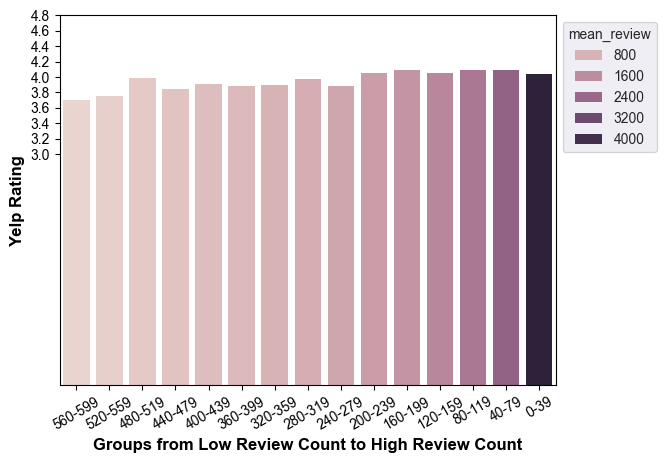

In [65]:
#Creates a bar plot with my dataframe rateRev
sns.barplot(x = 'mean_review',
            y = 'mean_rating',
            data = rateRev,
            hue = 'mean_review')
#Sets the dark grid in the background
sns.set_style("darkgrid")
#legend placement, legend title
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='mean_review')
#Renames x values to their corresponding index_group for easy viewing
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14),
           ('560-599', '520-559', '480-519', '440-479', '400-439','360-399', '320-359', '280-319', '240-279', '200-239', '160-199', '120-159', '80-119',
           '40-79', '0-39'))
plt.xticks(rotation=30)
#X and Y labels
plt.xlabel('Groups from Low Review Count to High Review Count', fontsize = 12, weight = 'bold')
plt.ylabel('Yelp Rating', fontsize = 12, weight = 'bold')
#Sets the y-ticks to increment by 0.2, range from 3-5
plt.yticks(np.arange(3, 5, .2))
plt.show()

The average rating of businesses with the <u>most reviews</u> (`index group 0-39`) is `4.038` and their average amount of reviews is `4404.000`.

The average rating of businesses with the <u>least reviews</u> (`index group 560-599`) is `3.705` and their average amount of reviews is `72.641`.

The top 200 businesses with the most reviews were rated at least `4.0` on average whereas the rest of the business groups had a `mean_rating` of <`4.0`. However, there are some groups that have a *higher* `mean_review` than other groups but were assigned a *lower* `mean_rating`. For instance: `index group 480-519` has a `mean_rating` of `3.988` and a `mean_review` of `309.575`, but `index group 240-279` has a lower `mean_rating` of `3.888` and a higher `mean_review` of `1047.575`.

Overall, amount of reviews does not have a notable relationship with business rating.


*Note: Numbers were rounded to the nearest thousandths.*

#### Q2: What is the average rating of businesses based on their amount check-ins and how are these 2 variables related?

To address this question, I will sort the businesses from most check-ins to least check-ins, split them up into 15 groups, and utilize similar functions defined in the previous question to display the data and produce a graph.

In [66]:
#Stores the index of the sorted review_count into the variable "checkinIdx"
checkinIdx = yelpData['checkin_count'].sort_values(ascending=False).index

In [67]:
#Puts the sorted checkin_count into a dataframe and resets the index to 0
df_check = yelpData.reindex(checkinIdx).reset_index(drop=True)
df_check.head()

,business_id,name,rating,review_count,checkin_count,category,city,state,zip_code
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,52144,Airports,Philadelphia,PA,19153
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,40109,Donuts,New Orleans,LA,70116
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,37562,Airports,Kenner,LA,70062
3,c_4c5rJECZSfNgFj7frwHQ,Tampa International Airport,4.0,2033,37518,Airports,Tampa,FL,33607
4,4i4kmYm9wgSNyF1b6gKphg,Nashville International Airport - BNA,3.5,1140,31168,Airports,Nashville,TN,37214


In [68]:
#Dividing the businesses by groups of 40 from most amount of check-ins to least amount of check-ins
check1 = df_check.iloc[:40]
check2 = df_check.iloc[40:80]
check3 = df_check.iloc[80:120]
check4 = df_check.iloc[120:160]
check5 = df_check.iloc[160:200]
check6 = df_check.iloc[200:240]
check7 = df_check.iloc[240:280]
check8 = df_check.iloc[280:320]
check9 = df_check.iloc[320:360]
check10 = df_check.iloc[360:400]
check11 = df_check.iloc[400:440]
check12 = df_check.iloc[440:480]
check13 = df_check.iloc[480:520]
check14 = df_check.iloc[520:560]
check15 = df_check.iloc[560:600]

In [69]:
#Puts each group of 40 businesses in the list "checkDfs"
checkDfs = [check1, check2, check3, check4, check5, check6, check7, check8, check9, check10, check11, check12, check13, check14, check15]

In [70]:
#Gets the average checkin_count for each group
def avgCheck(df):
    avg = []
    avg.append(df['checkin_count'].mean())
    return avg

In [71]:
#Gets the min and max of checkin_count for each group
def min_Max(df):
    minMaxList = []
    oneBiz = []
    oneBiz.append(df['checkin_count'].min())
    oneBiz.append(df['checkin_count'].max())
    minMaxList.append(oneBiz)
    return minMaxList

In [72]:
#Intializing the list that will contain the min and max checkin_count for each business in each of the 15 groups
checkRange = []
#Initializing list that will contain average checkin_count for each group
meanCheck = []
#Initializes list that will contain the rating mean for each group
meanRating = []

for df in checkDfs:
    #Utilizes the mean() function defined for the previous question to get the rating mean for each group
    meanRating.extend(mean(df))
    checkRange.extend(min_Max(df))
    meanCheck.extend(avgCheck(df))

In [73]:
#Prints the lowest amount of check-ins for a business in a group as well as the highest amount of check-ins for a business in a group
print('Printing CheckRange')
print(checkRange)
#Prints the average checkin_count for each group
print('Printing meanCheck')
print(meanCheck)
#Prints the average rating for each group
print('Printing meanRating')
print(meanRating)

Printing CheckRange
[[6365, 52144], [4582, 6356], [3802, 4487], [3454, 3799], [3150, 3432], [2954, 3143], [2710, 2934], [2570, 2710], [2430, 2560], [2330, 2428], [2252, 2330], [2165, 2250], [2094, 2165], [2012, 2093], [1936, 2012]]
Printing meanCheck
[14535.925, 5224.925, 4113.825, 3616.225, 3282.85, 3058.1, 2823.775, 2636.1, 2501.1, 2375.7, 2282.175, 2207.65, 2130.3, 2052.525, 1970.6923076923076]
Printing meanRating
[3.8875, 3.9125, 4.0625, 4.0625, 4.0, 3.9625, 4.0125, 4.0125, 4.0875, 3.9375, 3.925, 3.8375, 3.825, 3.85, 3.871794871794872]


I have gathered the information that pertains to this question, so now I will create a dataframe for each of the 15 groups.

The dataframe will have a column called `lowest_checkin_count` which states the *lowest* amount of check-ins a business received in that group and a column called `highest_checkin_count` which states the *highest* amount of check-ins a business received in that group. Similar to the dataframe from the previous question, I will add a column called `mean_rating` which displays the average rating for the businesses each group.

In [74]:
#Creates the dataframe for each of the 15 groups
rateCheck = pd.DataFrame(checkRange, columns=['lowest_checkin_count', 'highest_checkin_count'])

#Adds the mean_rating column
rateCheck['mean_rating'] = meanRating
#Adds a columns that gives the mean checkin_count for each group
rateCheck['mean_checkin'] = meanCheck
#Variable specifying which group is for which indexes
groupL = ['0-39', '40-79', '80-119', '120-159', '160-199', '200-239', '240-279', '280-319',
            '320-359', '360-399', '400-439', '440-479', '480-519', '520-559', '560-599']
#Adds a column specifying which group is which
rateCheck['index_group'] = groupL

#Rearranges the columns
rateCheck = rateCheck.iloc[:, [4, 2, 0, 1, 3]]

#Outputs the created dataframe to show the changes
rateCheck.head(15)

,index_group,mean_rating,lowest_checkin_count,highest_checkin_count,mean_checkin
0,0-39,3.887500,6365,52144,14535.925000
1,40-79,3.912500,4582,6356,5224.925000
2,80-119,4.062500,3802,4487,4113.825000
3,120-159,4.062500,3454,3799,3616.225000
4,160-199,4.000000,3150,3432,3282.850000
5,200-239,3.962500,2954,3143,3058.100000
6,240-279,4.012500,2710,2934,2823.775000
7,280-319,4.012500,2570,2710,2636.100000
8,320-359,4.087500,2430,2560,2501.100000
9,360-399,3.937500,2330,2428,2375.700000


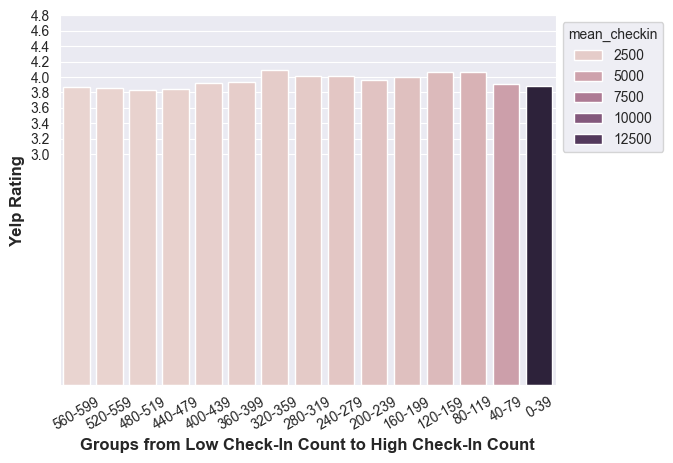

In [75]:
#Creates a bar plot with my dataframe rateCheck
sns.barplot(x = 'mean_checkin',
            y = 'mean_rating',
            hue = 'mean_checkin',
            data = rateCheck)
#Sets the dark grid in the background
sns.set_style("darkgrid")
#legend placement, legend title
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='mean_checkin')
#Renames x values to their corresponding index_group for easy viewing
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14),
           ('560-599', '520-559', '480-519', '440-479', '400-439','360-399', '320-359', '280-319', '240-279', '200-239', '160-199', '120-159', '80-119',
           '40-79', '0-39'))
plt.xticks(rotation=30)
#X and Y labels
plt.xlabel('Groups from Low Check-In Count to High Check-In Count', fontsize = 12, weight = 'bold')
plt.ylabel('Yelp Rating', fontsize = 12, weight = 'bold')
#Sets the y-ticks to increment by 0.2, range from 3-5
plt.yticks(np.arange(3, 5, .2))
plt.show()

In [76]:
#Displays the category value for the top 6 rows with the most check-ins
df_check.category.head(6)

0    Airports
1      Donuts
2    Airports
3    Airports
4    Airports
5    Airports
Name: category, dtype: object

The average rating of businesses with the <u>most check-ins</u> (`index group 0-39`) is `3.888` and their average amount of check-ins is `14535.925`. Considering 5 out of the 6 businesses with the most check-ins are `Airports`, a large amount of check-ins makes sense.

The average rating of businesses with the <u>least check-ins</u> (`index group 560-599`) is `3.872` and their average amount of check-ins is `1970.692`.

The `index group 320-359` had the highest `mean_rating` with a value of `4.088` and a `mean_checkin` of `2501.100`.

These findings suggest that there is no relationship between the amount of check-ins and the rating of a business.


*Note: Numbers were rounded to the nearest thousandths.*

In [77]:
#Total amount of check-ins + reviews for all businesses in the combined dataframe
print('Total amount of check-ins in the YelpData dataframe:')
print(yelpData.checkin_count.sum())
print('Total amount of reviews in the YelpData dataframe:')
print(yelpData.review_count.sum())

Total amount of check-ins in the YelpData dataframe:
2190504
Total amount of reviews in the YelpData dataframe:
733650


The total amount of check-ins is almost 3 times the total amount of reviews.
A reason for this may be because submitting a check-in for a business on Yelp tends to be much less time-consuming than posting a Yelp review. Yelp users can easily submit a check-in without typing any words, whereas posting a review requires the user to type at least 85 characters in their review.

Initially, I thought that businesses with more check-ins would have a slight tendency to rate higher than businesses with less check-ins. The analysis showed that is not the case. Amount of check-ins is not a notable factor for predicting the rating of a business.

#### Q3: What is the relationship between Yelp user interactions (check-ins + reviews) and the rating given to a business?

To examine the relationship between these variables, I will create a new column that lists the total amount of Yelp user interactions (check-ins + reviews) called `total_interaction` and compare it with `rating`. I chose to explore this relationship because I was curious to see how a Yelp user's opinion of a business affected their interactions with a business' page on Yelp and vice-versa. 

In [78]:
#Copies the dataframe
yelpInt = yelpData.copy()

In [79]:
#Creates a new column that presents the total amount of Yelp user interactions by adding review_count and checkin_count
yelpInt['total_interaction'] = yelpInt['review_count'] + yelpInt['checkin_count']
#Loads the changed dataframe
yelpInt.head(3)

,business_id,name,rating,review_count,checkin_count,category,city,state,zip_code,total_interaction
0,-QI8Qi8XWH3D8y8ethnajA,Philadelphia International Airport - PHL,2.5,2338,52144,Airports,Philadelphia,PA,19153,54482
1,FEXhWNCMkv22qG04E83Qjg,Cafe Du Monde,4.0,3126,40109,Donuts,New Orleans,LA,70116,43235
2,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airp...,3.0,1969,37562,Airports,Kenner,LA,70062,39531


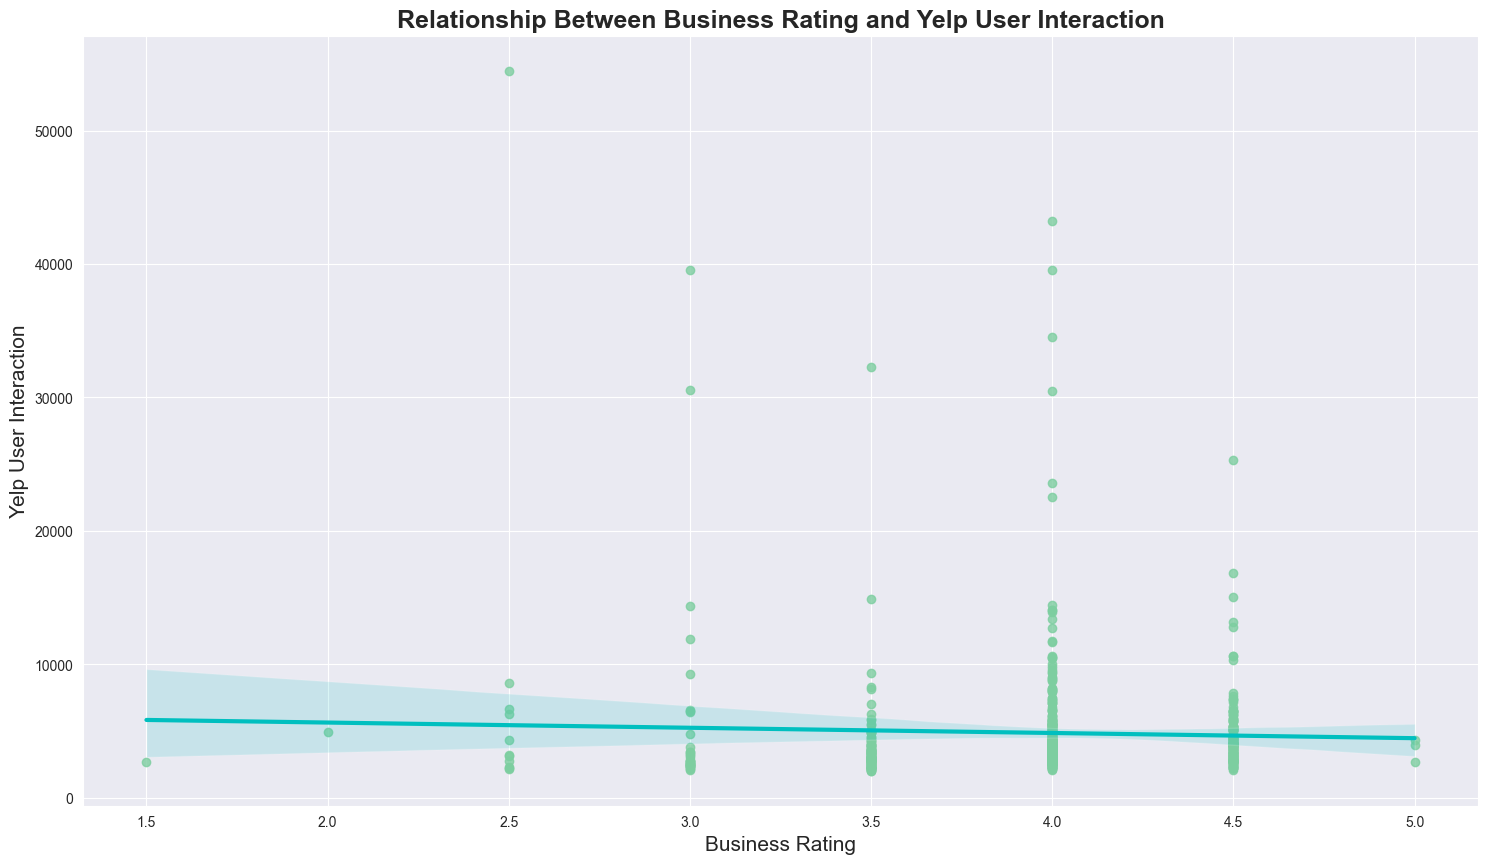

In [80]:
#Set data to yelpInt dataframe
data = yelpInt
fig, ax = plt.subplots()
#Sets the size of the plot
fig.set_size_inches(18, 10)
#Plots the scatterplot with a regression line to show the relationship between rating and total_interaction,
#sets the colors of the plot and width of the regression line
sns.regplot(x = yelpInt['rating'], y = yelpInt['total_interaction'], scatter_kws={'color': '#7DCEA0'}, line_kws={'color':'c','lw':3})
#Sets plot title
plt.title('Relationship Between Business Rating and Yelp User Interaction', weight = 'bold', fontsize = 18)
#X and Y labels
plt.xlabel('Business Rating', fontsize = 15)
plt.ylabel('Yelp User Interaction', fontsize = 15);

In [81]:
yelpInt['rating'].corr(yelpInt['total_interaction'])

-0.03890380664265708

The plot above illustrates that a majority of the businesses are rated around 3.0-4.5 out of 5.0. There are few businesses rated very high (5.0) or very low (1.5).

There is no correlation between business rating and yelp user interaction with a correlation of -0.0389. The regression line on the plot demonstrates there is no significant relationship between `rating` and `total_interaction`.

Considering that the previous graphs showed that `checkin_count` has no relationship with business `rating` and that `review_count` is not a reliable indicator of `rating`, the lack of relationship between `rating` and `total_interaction` makes sense.

## Conclusions
Prior to conducting my analysis, I speculated that businesses with more reviews or check-ins had a higher probability of having a higher rating than businesses with less reviews or check-ins. I expected that Yelp businesses that have established a decent rating (3.5-5.0) would attract more customers, increasing their amount of Yelp user reviews and check-ins. I also expected that Yelp businesses with a lot of Yelp user interactions would gain more popularity and traction, causing an increase of hype and customers. While this may be true in some cases, my analyses demonstrated that this is not the case for the overall dataset.

My analysis in question 1 revealed that some businesses have a higher `mean_rating` than other businesses despite having a lower average amount of reviews. There were also businesses that had a lower `mean_rating` with a higher average amount of reviews compared to other businesses. This findings indicate that there is no significant relationship between review count and business rating.

My analysis in question 2 revealed that businesses with a higher amount of check-ins do not have a higher probability of having a higher rating. `index_group 320-359` has a `mean_checkin` of 2501.100 and has the highest `mean_rating` at 4.088. I suppose this can be explained by a multitude of factors. One explanation may be that checking into a Yelp business is a lot less time-consuming and less effort than writing a review for a business. Because it's less time-consuming, many people check into a business regardless of whether they have a positive or a negative opinion about the business.

I'm somewhat surprised that `total_interaction` does not have a notable influence on business `rating` and vice-versa. My analysis for question 3 illustrated the lack of relationship between business `rating` and `total_interaction`. In conclusion, the quantity of Yelp reviews and check-ins are not reliable factors in predicting a business' rating. These 3 variables are not statistically related.

*Note: Numbers were rounded to the nearest thousandths.*

### Reflection
I would be interested in exploring the relationship between business `rating` and `total_interaction` based on different states or major metropolitan areas. I'm curious to see if the correlation between the 2 variables differ based on location or regional culture. I would also be interested in working with a dataset made from machine learning that predicts whether Yelp users' reviews are negative or positive.

### References:

**DATASET**
- [Yelp Open Dataset](https://www.yelp.com/dataset) This is the Yelp open dataset where I acquired Dataset 1.

- [Yelp Fusion API](https://docs.developer.yelp.com/docs/fusion-intro) Guided me on how to apply for Yelp API access + how to use the features of the Yelp API (Dataset 2).

- [Youtube](https://www.youtube.com/watch?v=oggMBtza80E) This video helped me learn how to make requests to Yelp's API.


**Other References**

[Stack Overflow](https://stackoverflow.com/questions/30202011/how-can-i-count-comma-separated-values-in-one-column-of-my-panda-table) Taught me how to count comma separated values.

[Stack Overflow](https://stackoverflow.com/questions/54426845/how-to-check-if-a-pandas-dataframe-contains-only-numeric-values-column-wise) Taught me how to check if a column only contains numerical values.

[Stack Overflow](https://stackoverflow.com/questions/54084166/how-to-extract-entire-part-of-string-after-certain-character-in-dataframe-column) Taught me how to extract a specific part of a string based on its adjacent characters.

[Stack Overflow](https://stackoverflow.com/questions/31556424/how-do-i-change-the-plot-size-of-a-regplot-in-seaborn) Instructed me on how to change the size of my Seaborn regplot.

[Stack Overflow](https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot) Where I learned how to change the colors in my Seaborn regplot.

[Medium](https://medium.com/black-tech-diva/hide-your-api-keys-7635e181a06c) How I hid my API key to adhere to Yelp's terms of use.